## Quora Kaggle competition

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on Quora, a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

In [13]:
import numpy as np
import pandas as pd
import os,re
import seaborn as sns
import gensim as gn
import logging
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.word2vec import Word2Vec
import nltk
import scipy.sparse as sparse
from nltk.data import load
from fuzzywuzzy import fuzz
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.set_option('display.max_columns', 200)

### Training data

In [34]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [6]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for test data: {}'.format(len(df_test)))
print('Duplicate pairs : {} %'.format(round(df_train['is_duplicate'].mean()*100,2)))

Total number of question pairs for training: 10000
Total number of question pairs for test data: 10000
Duplicate pairs : 37.46 %


## Generate features

### Text handcrafted features (fs_1)

In [7]:
def generate_features(df_train):
    df_train['len_q1'] = df_train['question1'].apply(lambda x:len(str(x)))
    df_train['len_q2'] = df_train['question2'].apply(lambda x:len(str(x)))
    df_train['diff_len'] = df_train.len_q1-df_train.len_q2
    df_train['len_char_q1'] = df_train.question1.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_char_q2'] = df_train.question2.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_word_q1'] = df_train.question1.apply(lambda x:len(str(x).split()))
    df_train['len_word_q2'] = df_train.question2.apply(lambda x:len(str(x).split()))
    df_train['common_words'] = df_train.apply(lambda x:len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))),axis=1)

    df_train['fuzzy_qratio'] = df_train.apply(lambda x: fuzz.QRatio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_wratio'] = df_train.apply(lambda x:fuzz.WRatio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_ratio'] = df_train.apply(lambda x:fuzz.partial_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_token_set_ratio'] = df_train.apply(lambda x:fuzz.partial_token_set_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_token_sort_ratio'] = df_train.apply(lambda x:fuzz.partial_token_sort_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_token_sort_ratio'] = df_train.apply(lambda x:fuzz.token_sort_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_token_set_ratio'] = df_train.apply(lambda x:fuzz.token_set_ratio(str(x['question1']),str(x['question2'])),axis=1)
    return df_train

In [8]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio,fuzzy_partial_token_set_ratio,fuzzy_partial_token_sort_ratio,fuzzy_token_sort_ratio,fuzzy_token_set_ratio
273872,273872,392405,392406,What are the pros & cons of democracy?,What are the pros and cons of a democracy?,1,38,42,-4,17,16,8,9,7,92,95,87,100,100,92,100
342308,342308,438846,462606,How will Brexit impact the flow of goods and p...,Can a post-Brexit Britain really survive witho...,1,105,145,-40,26,30,18,22,7,59,71,68,100,63,65,75
353135,353135,482139,482140,If I got a Buddhist tattoo would I be disrespe...,"Do many Buddhists actually ""throw away the raft""?",0,85,49,36,22,21,15,8,1,37,86,37,100,50,45,50


### LDA (Lattent Dirichlet Allocation) features 

In [10]:
# Steaming 
p_stemmer = PorterStemmer()
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

# Function to vuild a corpus
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [14]:
data = clean_dataframe(df_train)
corpus = build_corpus(data)
dictionary = corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in corpus]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary)

2017-04-06 00:03:31,122 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-06 00:03:31,293 : INFO : adding document #10000 to Dictionary(12038 unique tokens: [u'', u'unscientific', u'yellow', u'four', u'payoneer']...)
2017-04-06 00:03:31,463 : INFO : built Dictionary(15780 unique tokens: [u'', u'unscientific', u'yellow', u'four', u'payoneer']...) from 20000 documents (total 108944 corpus positions)
2017-04-06 00:03:31,698 : INFO : using symmetric alpha at 0.01
2017-04-06 00:03:31,699 : INFO : using symmetric eta at 6.3371356147e-05
2017-04-06 00:03:31,702 : INFO : using serial LDA version on this node
2017-04-06 00:03:39,784 : INFO : running online LDA training, 100 topics, 1 passes over the supplied corpus of 20000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-04-06 00:03:39,787 : INFO : PROGRESS: pass 0, at document #2000/20000
2017-04-06 00:03:41,688 : 

In [16]:
def common_lda_topic(sentence1,sentence2,dictionary,ldamodel,min_proba):
    "find #common topic based on lattent dirichlet allocation model"
    sentence1 = sentence1.split()
    sentence2 = sentence2.split()

    sentence1 = dictionary.doc2bow(sentence1)
    sentence2 = dictionary.doc2bow(sentence2)
    
    topic_a = ldamodel.get_document_topics(sentence1,minimum_probability=min_proba)
    topic_b = ldamodel.get_document_topics(sentence2,minimum_probability=min_proba)
    
    topic_a = list(sorted(topic_a, key=lambda x: x[1]))
    topic_b = list(sorted(topic_b, key=lambda x: x[1]))
    common_topic = set([x[0] for x in topic_a]).intersection(x[0] for x in topic_b)
    return(len(common_topic))

In [17]:
#vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)
#pyLDAvis.display(vis_data)

In [18]:
df_train['common_topics'] = df_train.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)
df_test['common_topics'] = df_test.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)

### POS-Tagging features

In [19]:
def common_pos_tagging(question1,question2):
    question1 = nltk.word_tokenize(question1)
    question2 = nltk.word_tokenize(question2)
    pos_question1 = nltk.pos_tag(question1)
    pos_question2 = nltk.pos_tag(question2)

    pos_1_array = [x[1] for x in pos_question1]
    pos_2_array = [x[1] for x in pos_question2]
    return(len(set(pos_1_array).intersection(pos_2_array)))

In [20]:
def count_distinct_pos_tagging(df_train):
    #Generate all pos-tag null columns
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    pos_tag = tagdict.keys()
    for tag in pos_tag:
        df_train[tag+"_q1"] = 0
        df_train[tag+"_q2"] = 0
        
    for index, row in df_train.iterrows():
        question1 = row.question1.decode('utf-8')
        question1 = nltk.word_tokenize(question1)

        question2 = row.question2.decode('utf-8')
        question2 = nltk.word_tokenize(question2)

        pos_question1 = nltk.pos_tag(question1)
        pos_question1 = [x[1] for x in pos_question1]

        pos_question2 = nltk.pos_tag(question2)
        pos_question2 = [x[1] for x in pos_question2]

        for tag in pos_question1:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q1",row[tag+"_q1"]+1)

        for tag in pos_question2:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q2",row[tag+"_q2"]+1)

In [21]:
df_train['common_pos_count'] = df_train.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
df_test['common_pos_count'] = df_test.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
count_distinct_pos_tagging(df_train)
count_distinct_pos_tagging(df_test)

In [14]:
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio,fuzzy_partial_token_set_ratio,fuzzy_partial_token_sort_ratio,fuzzy_token_sort_ratio,fuzzy_token_set_ratio,common_topics,common_pos_count,PRP$_q1,PRP$_q2,VBG_q1,VBG_q2,VBD_q1,VBD_q2,``_q1,``_q2,VBN_q1,VBN_q2,",_q1",",_q2",''_q1,''_q2,VBP_q1,VBP_q2,WDT_q1,WDT_q2,JJ_q1,JJ_q2,WP_q1,WP_q2,VBZ_q1,VBZ_q2,DT_q1,DT_q2,RP_q1,RP_q2,$_q1,$_q2,NN_q1,NN_q2,)_q1,)_q2,(_q1,(_q2,FW_q1,FW_q2,POS_q1,POS_q2,._q1,._q2,TO_q1,TO_q2,LS_q1,LS_q2,RB_q1,RB_q2,:_q1,:_q2,NNS_q1,NNS_q2,NNP_q1,NNP_q2,VB_q1,VB_q2,WRB_q1,WRB_q2,CC_q1,CC_q2,PDT_q1,PDT_q2,RBS_q1,RBS_q2,RBR_q1,RBR_q2,CD_q1,CD_q2,PRP_q1,PRP_q2,EX_q1,EX_q2,IN_q1,IN_q2,WP$_q1,WP$_q2,MD_q1,MD_q2,NNPS_q1,NNPS_q2,--_q1,--_q2,JJS_q1,JJS_q2,JJR_q1,JJR_q2,SYM_q1,SYM_q2,UH_q1,UH_q2
273872,273872,392405,392406,What are the pros & cons of democracy?,What are the pros and cons of a democracy?,1,38,42,-4,17,16,8,9,7,92,95,87,100,100,92,100,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
342308,342308,438846,462606,How will Brexit impact the flow of goods and p...,Can a post-Brexit Britain really survive witho...,1,105,145,-40,26,30,18,22,7,62,71,71,100,63,65,75,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
353135,353135,482139,482140,If I got a Buddhist tattoo would I be disrespe...,"Do many Buddhists actually ""throw away the raft""?",0,85,49,36,22,21,15,8,1,44,86,49,100,54,51,55,1,6,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Word2vec features 
Word2Vec creates a multi-dimensional vector for every word in the english vocabulary (or the corpus it has been trained on). Word2Vec embeddings are very popular in natural language processing and always provide us with great insights. Wikipedia provides a good explanation of what these embeddings are and how they are generated (https://en.wikipedia.org/wiki/Word2vec).

In [23]:
norm_model = gn.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

2017-04-06 00:19:08,626 : INFO : loading projection weights from ./data/GoogleNews-vectors-negative300.bin
2017-04-06 00:20:21,813 : INFO : loaded (3000000, 300) matrix from ./data/GoogleNews-vectors-negative300.bin


In [33]:
print("Word2vec mean of president : {} mean of obama {}".format(norm_model['president'].mean(),norm_model['king'].mean()))

Word2vec mean of president : 0.0164027865976 mean of obama 0.00492879888043


## Extract features important with ExtraTreesClassifier
LDA is a supervised stastical technique to reduce dimensions

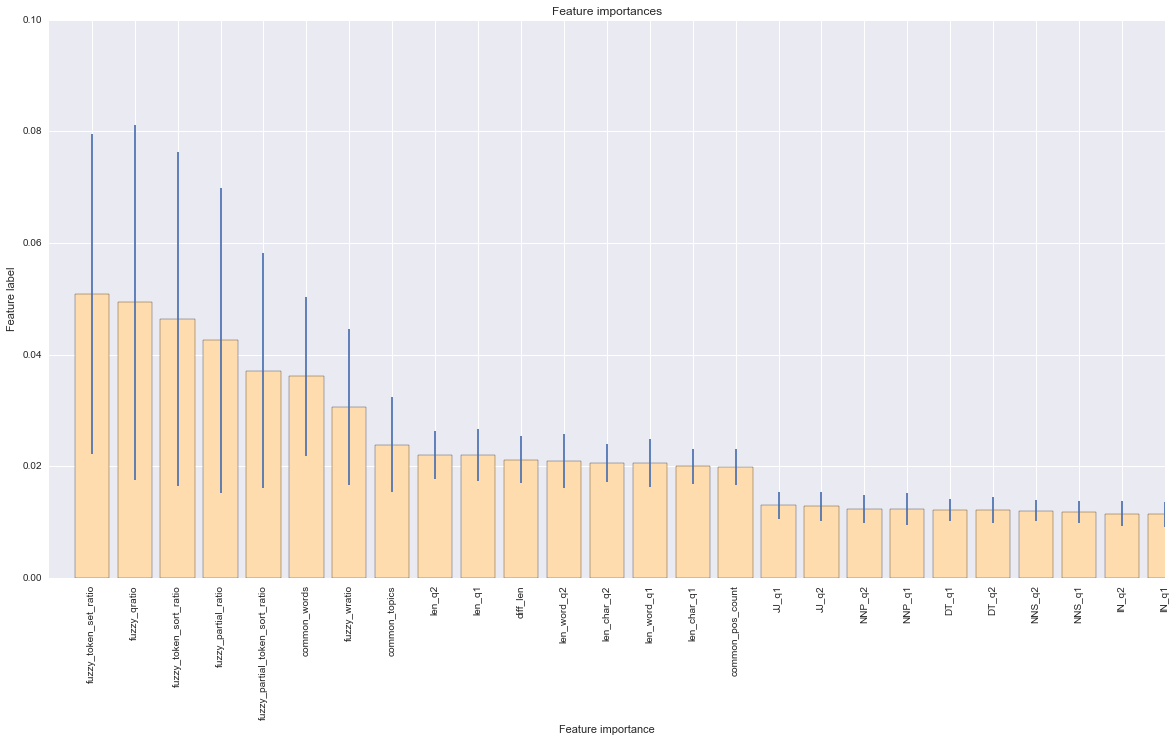

fuzzy_qratio


In [33]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
train = df_train.ix[:, 6:,]
forest.fit(train, df_train.is_duplicate)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
list = train.columns.values
# Print the feature ranking
#print("Feature ranking:")

#for f in range(train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],color='#ffdcad', yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), list[indices],rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0,.1])
plt.xlabel("Feature importance")
plt.ylabel("Feature label")
plt.show()

## Logistic Regression 

In [43]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg2 = linear_model.LogisticRegression(C=1e5)
X = df_train.ix[:, 6:,]
Y = df_train.is_duplicate

In [44]:
print('Train shape : {}, Test shape : {}'.format(X.shape,df_test.ix[:, 3:,].shape))

Train shape : (10000, 107), Test shape : (10000, 107)


In [46]:
logreg.fit(X, Y)
logreg2.fit(Xr_Train,Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [55]:
proba_replicated = logreg.predict_proba(df_test.ix[:, 3:,])
proba = proba_replicated[:,1]
len(proba)
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = proba
sub.to_csv('simple_xgb.csv', index=False)

### Log loss cross validation

In [54]:
scores = cross_val_score(logreg, X, Y, cv=5, scoring='accuracy')
scores2 = cross_val_score(logreg2, Xr_Test, Y, cv=5, scoring='accuracy')
print('Without DR score {}, with DR {} '.format(scores.mean(),scores2.mean()))

Without DR score 0.698298819275, with DR 0.624500112475 


### Train Word2vec model

In [87]:
STOP_WORDS = nltk.corpus.stopwords.words()
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(df_train)
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio
273872,273872,392405,392406,pros cons democracy,pros cons democracy,1,38,42,-4,17,16,8,9,7,92,95,87
342308,342308,438846,462606,brexit impact flow goods people northern irela...,postbrexit britain really survive without land...,1,105,145,-40,26,30,18,22,7,62,71,71
353135,353135,482139,482140,got buddhist tattoo would disrespecting people...,many buddhists actually throw away raft,0,85,49,36,22,21,15,8,1,44,86,49
332098,332098,338155,31995,create instagram account,track created instagram account,0,39,54,-15,18,18,7,10,3,70,70,77
176156,176156,271084,271085,hulu plus free trial really free,long hulu plus free trial,0,36,37,-1,15,17,7,8,4,65,83,67


### Create submission file

In [325]:
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]